We will do some exploratory data analysis on the adult mouse hippocampus dataset that you just preprocessed.

Here, we show our code and results as a jupyter notebook, but you can copy and paste the code into a standalone script, and it will still work.

## Loading the modules

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

In [3]:
adata = sc.read_h5ad("alignment/openst_demo_adult_mouse_by_cell.h5ad")

After transfering the segmentation information, the cell with the identifier 0 will have all the transcripts belonging to the background. 
Therefore, make sure to omit it from the dataset.

!!! tip
    We all know that views in `anndata` can be a bit problematic sometimes... You might want to append `.copy()` at the end of the following line of code if you encounter issues.

In [4]:
adata = adata[adata.obs.cell_ID_mask != 0].copy()

## Calculating QC metrics of the sample

Now, we can show different plots (histograms) to assess the number of unique transcripts (UMIs), genes, percentage of mitochondrial transcripts per segmented cell, as a quick way of assessing the quality of the dataset. This will help to decide on filtering thresholds, to remove potential low quality cells (i.e., due to poor sequencing coverage, or wrong segmentation of background as cells).

In [5]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<AxesSubplot: xlabel='n_genes_by_counts', ylabel='Count'>

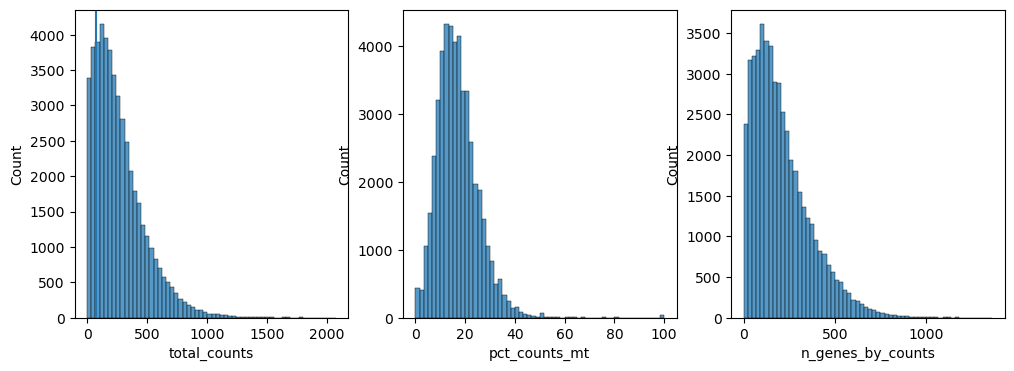

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(adata.obs["total_counts"], kde=False, bins=60, ax=axs[0])
axs[0].axvline(75, 0,19000)
sns.histplot(adata.obs["pct_counts_mt"], kde=False, bins=60, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])

Here we apply the following filters, decided by looking at the histogram. You can be more conservative, we chose these in order to keep most of the cells while removing very obvious *bad quality* data points.

In [9]:
# Filter data
sc.pp.filter_cells(adata, min_counts=75)
sc.pp.filter_cells(adata, max_counts=10000)
# sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 30]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10) 

#cells after MT filter: 39087


/home/dleonpe/miniconda3/envs/napari-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


## Normalization

From this point, some of the analysis decisions are just heuristics taken from single cell analysis. We would not say these are the *best* possible practices for analyzing this data, but the most *common* ones. Especially, regarding normalization (see *Warning* below).

Let's apply the *common* normalization to $10^4$ counts per cell, and the log-normalization with pseudocount. This is supposed to stabilize the variance of genes and remove potential biases from sequencing depth per cell.

In [10]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

!!! warning
    Normalization is necessary, i.e., to account for the differences in depth per cell and remove potential biases, or to estabilize the variance of genes and remove their dependency on the counts. 
    
    It is still under study, but normalization strategies for single-cell are most likely not well suited for this kind of high-resolution, single-cell spatial data. Especially, since counts have an additional source of (spatial) coviariance that does not exist in single-cell datasets. Therefore, it is possible that the covariance and errors from spatial components are propagated throughout the analysis pipeline, and some *signal* or *significant* results are just noise from the spatial autocorrelations. Anyway, we are using these common practices just as a way of getting a feeling about the data, and what could be genes playing a role at specific regions in space.

Now, we detect highly variable genes. Any of the `flavor`(s) are designed with single-cell data in mind, so the list of highly variable genes that they select will be likely affected by the spatial autocorrelation structure. Alternative strategies could be selecting these genes based on the spatial variable genes (e.g., by Moran's I value).

In [11]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

## Dimensionality reduction and clustering

We perform the dimensionality reduction with PCA, and community clustering of the nearest neighbors graph using the leiden algorithm. For this exploratory analysis, we keep the default parameters.

TODO: put the PCA loadings and select from this.

In [12]:
# Clustering & embedding
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution = 0.9, key_added="leiden")

Now we can take a look at the clusters in space. It seems like we recapitulate the major morphological structures from this tissue. We also show *Ttr*, a marker of the choroid plexus, which seems to be restricted to a specific location in space, that also clusters separately.

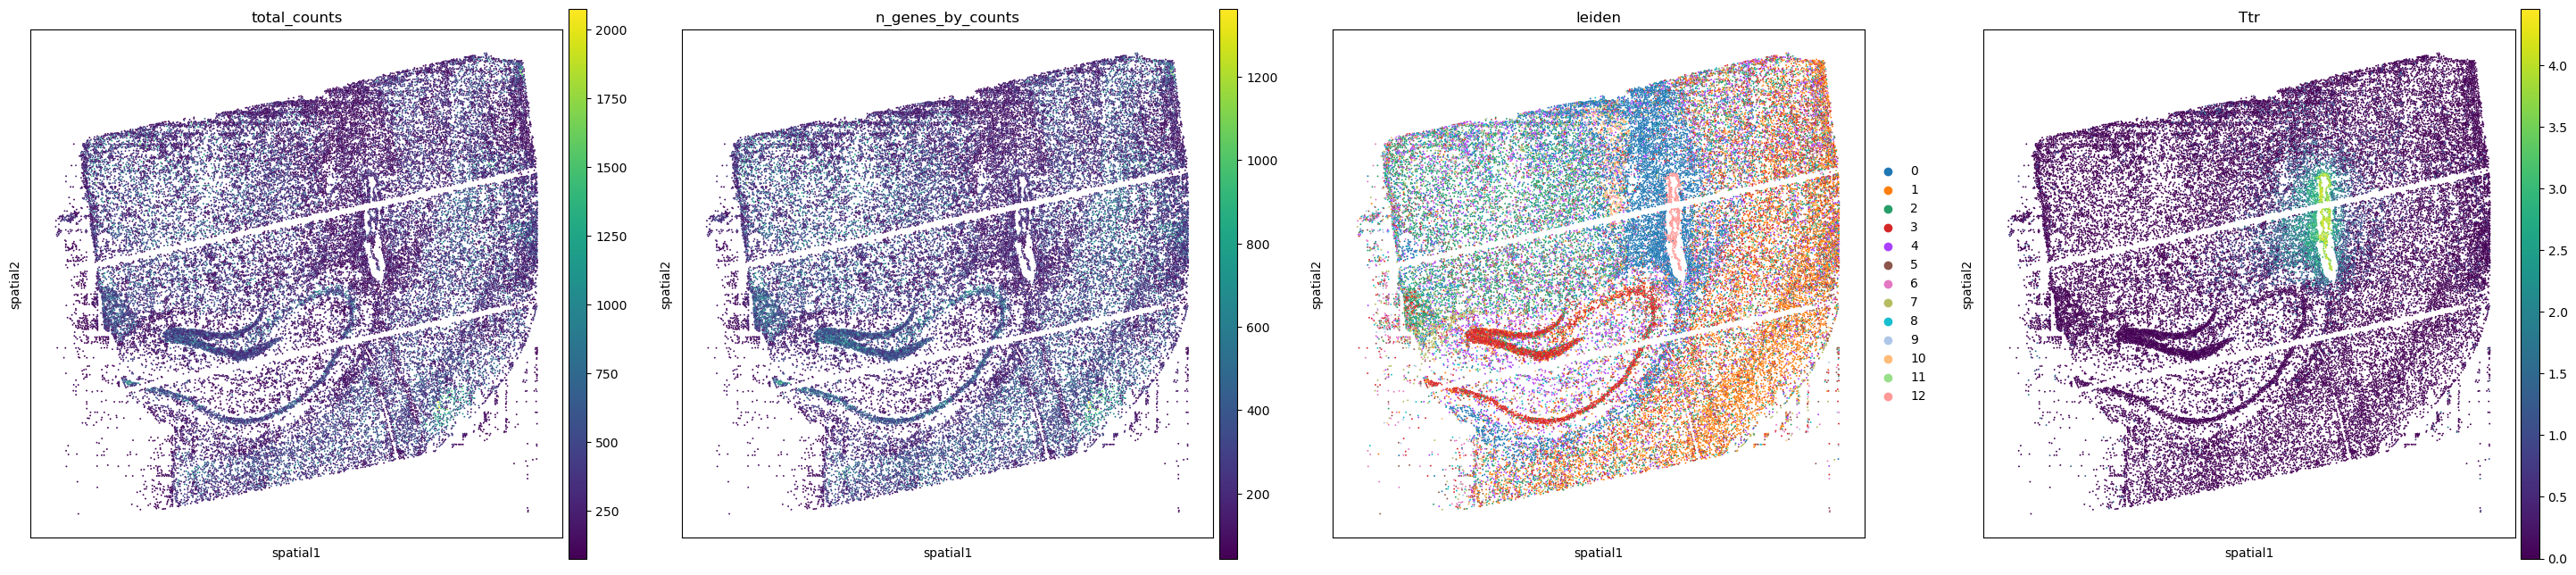

In [17]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key=None, color=["total_counts", "n_genes_by_counts", "leiden", "Ttr"], spot_size=40)

Notice how we didn't compute the typical UMAP. It might be useful in single cell data, but it does not mean much in this kind of spatial data. Basically, since the data per cell is not normalized using an appropriate method taking into account the spatial autocorrelation, the neighborhood graph might have bias depending on the local environment. Thus, UMAP amplifies this fact and leaves a visualization that is a mere picture of the physical 2d 'neighborhood' topology of the cells, rather than representing the local/global distances in transcriptomic space.

In [ ]:
sc.tl.umap(adata)

/home/dleonpe/miniconda3/envs/napari-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


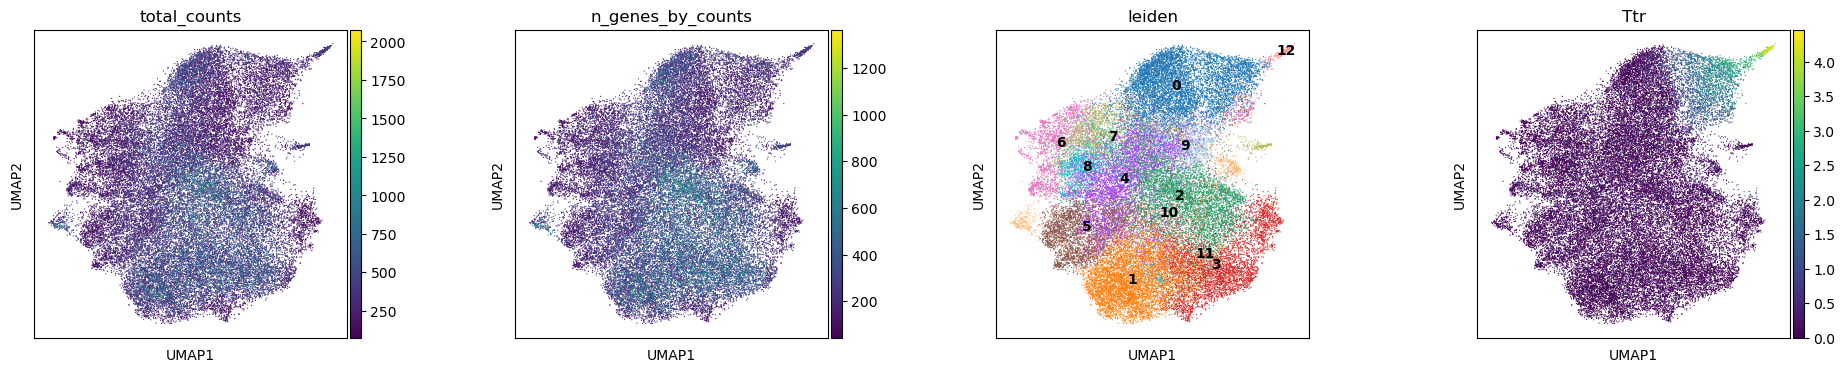

In [14]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "leiden", "Ttr"], wspace=0.4, legend_loc = "on data")

## Marker genes

A better way (compared to UMAP) of showing the pairwise relations of clusters and their transcriptomic identities is to use feature plots like dotplots or matrixplots showing the expression of significant markers of the inferred clusters, sorted following their dendrogram.

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden')
sc.tl.dendrogram(adata, 'leiden')

/home/dleonpe/miniconda3/envs/napari-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


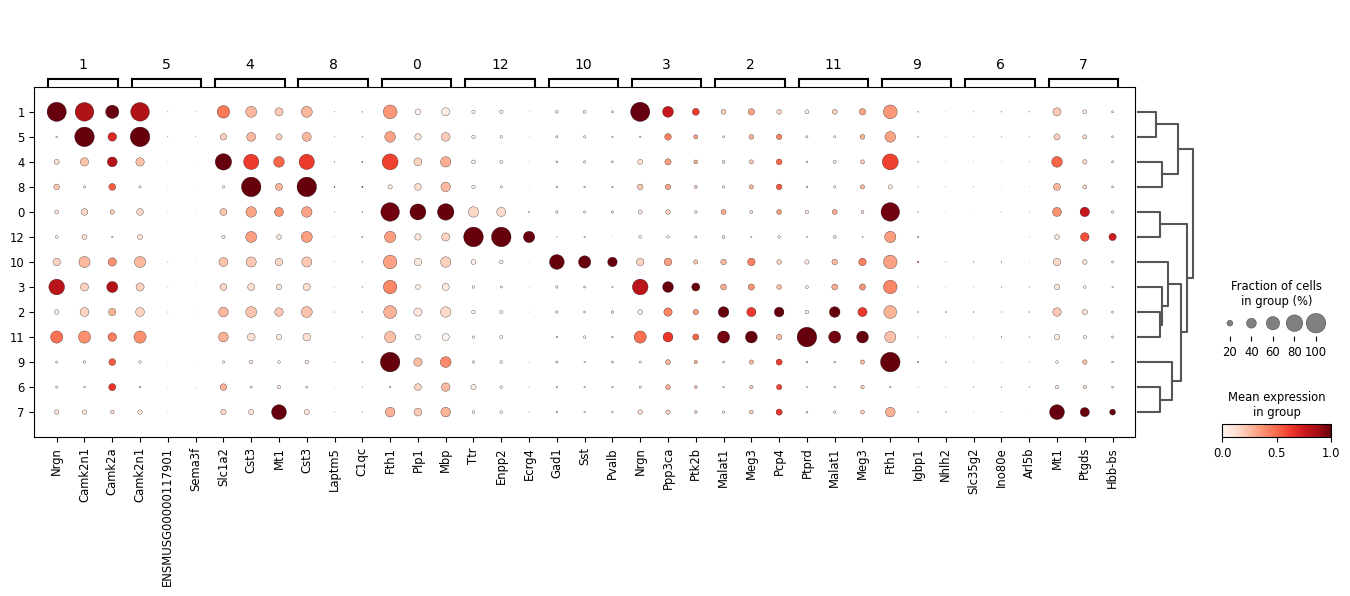

In [21]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, standard_scale='var', min_logfoldchange=1)

For instance, this confirms how *Ttr* is indeed a significant marker of cluster 12, which we could indeed annotate as *choroid plexus*.